<a href="https://colab.research.google.com/github/wlz99/c3aiHackathon/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [394]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/DMC20_Data/c3ai

In [396]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np

In [397]:
country_file = pd.read_excel('C3-ai-Location-IDs.xlsx', sheet_name="Country IDs", skiprows=2)
country_file.fillna(0,inplace=True)
country_file.replace('X', 1, inplace= True) # data accessible

In [398]:
state_file = pd.read_excel('C3-ai-Location-IDs.xlsx', sheet_name="Province & State IDs", skiprows=2)
state_file.fillna(0,inplace=True)
state_file.replace('X', 1, inplace= True) # data accessible

In [399]:
state_file['Country'] = state_file['Country '].str.strip()

In [400]:
us_state_file = state_file[state_file['Country'] == 'United States']

In [401]:
locations = list(us_state_file["Province or State"])#[:20]

In [402]:
import c3aidatalake

In [403]:
locs = set([loc + '_UnitedStates' for loc in locations])

In [404]:
today = pd.Timestamp.now() - datetime.timedelta(days = 7)
today = today.strftime("%Y-%m-%d")

# locations = [
#     "China"
# ]

metrics = [
    # "Apple_WalkingMobility", 
    "Google_GroceryMobility",
    "Google_ParksMobility",
    "Google_TransitStationsMobility",
    "Google_RetailMobility",
    "Google_ResidentialMobility",
    "Google_WorkplacesMobility"
]

complete_timeseries = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : [loc + '_UnitedStates' for loc in locations],
            "expressions" : metrics,
            "start" : "2020-02-15",
            "end" : today,
            "interval" : "DAY",
        }
    },
    get_all = True
)

complete_timeseries

,dates,NorthernMarianaIslands_UnitedStates.Google_RetailMobility.data,NorthernMarianaIslands_UnitedStates.Google_RetailMobility.missing,NorthernMarianaIslands_UnitedStates.Google_GroceryMobility.data,NorthernMarianaIslands_UnitedStates.Google_GroceryMobility.missing,NorthernMarianaIslands_UnitedStates.Google_TransitStationsMobility.data,NorthernMarianaIslands_UnitedStates.Google_TransitStationsMobility.missing,NorthernMarianaIslands_UnitedStates.Google_ParksMobility.data,NorthernMarianaIslands_UnitedStates.Google_ParksMobility.missing,Alabama_UnitedStates.Google_RetailMobility.data,Alabama_UnitedStates.Google_RetailMobility.missing,Alabama_UnitedStates.Google_GroceryMobility.data,Alabama_UnitedStates.Google_GroceryMobility.missing,Alabama_UnitedStates.Google_TransitStationsMobility.data,Alabama_UnitedStates.Google_TransitStationsMobility.missing,Alabama_UnitedStates.Google_ParksMobility.data,Alabama_UnitedStates.Google_ParksMobility.missing,VirginIslands_UnitedStates.Google_RetailMobility.data,VirginIslands_UnitedStates.Google_RetailMobility.missing,VirginIslands_UnitedStates.Google_GroceryMobility.data,VirginIslands_UnitedStates.Google_GroceryMobility.missing,VirginIslands_UnitedStates.Google_TransitStationsMobility.data,VirginIslands_UnitedStates.Google_TransitStationsMobility.missing,VirginIslands_UnitedStates.Google_ParksMobility.data,VirginIslands_UnitedStates.Google_ParksMobility.missing,AmericanSamoa_UnitedStates.Google_RetailMobility.data,AmericanSamoa_UnitedStates.Google_RetailMobility.missing,AmericanSamoa_UnitedStates.Google_GroceryMobility.data,AmericanSamoa_UnitedStates.Google_GroceryMobility.missing,AmericanSamoa_UnitedStates.Google_TransitStationsMobility.data,AmericanSamoa_UnitedStates.Google_TransitStationsMobility.missing,AmericanSamoa_UnitedStates.Google_ParksMobility.data,AmericanSamoa_UnitedStates.Google_ParksMobility.missing,Guam_UnitedStates.Google_RetailMobility.data,Guam_UnitedStates.Google_RetailMobility.missing,Guam_UnitedStates.Google_GroceryMobility.data,Guam_UnitedStates.Google_GroceryMobility.missing,Guam_UnitedStates.Google_TransitStationsMobility.data,Guam_UnitedStates.Google_TransitStationsMobility.missing,Guam_UnitedStates.Google_ParksMobility.data,...,Virginia_UnitedStates.Google_RetailMobility.data,Virginia_UnitedStates.Google_RetailMobility.missing,Virginia_UnitedStates.Google_GroceryMobility.data,Virginia_UnitedStates.Google_GroceryMobility.missing,Virginia_UnitedStates.Google_TransitStationsMobility.data,Virginia_UnitedStates.Google_TransitStationsMobility.missing,Virginia_UnitedStates.Google_ParksMobility.data,Virginia_UnitedStates.Google_ParksMobility.missing,Vermont_UnitedStates.Google_WorkplacesMobility.data,Vermont_UnitedStates.Google_WorkplacesMobility.missing,Vermont_UnitedStates.Google_ResidentialMobility.data,Vermont_UnitedStates.Google_ResidentialMobility.missing,WestVirginia_UnitedStates.Google_WorkplacesMobility.data,WestVirginia_UnitedStates.Google_WorkplacesMobility.missing,WestVirginia_UnitedStates.Google_ResidentialMobility.data,WestVirginia_UnitedStates.Google_ResidentialMobility.missing,Washington_UnitedStates.Google_WorkplacesMobility.data,Washington_UnitedStates.Google_WorkplacesMobility.missing,Washington_UnitedStates.Google_ResidentialMobility.data,Washington_UnitedStates.Google_ResidentialMobility.missing,Wyoming_UnitedStates.Google_WorkplacesMobility.data,Wyoming_UnitedStates.Google_WorkplacesMobility.missing,Wyoming_UnitedStates.Google_ResidentialMobility.data,Wyoming_UnitedStates.Google_ResidentialMobility.missing,Grand Princess_UnitedStates.Google_WorkplacesMobility.data,Grand Princess_UnitedStates.Google_WorkplacesMobility.missing,Grand Princess_UnitedStates.Google_ResidentialMobility.data,Grand Princess_UnitedStates.Google_ResidentialMobility.missing,Wisconsin_UnitedStates.Google_WorkplacesMobility.data,Wisconsin_UnitedStates.Google_WorkplacesMobility.missing,Wisconsin_UnitedStates.Google_ResidentialMobility.data,Wisconsin_UnitedStates.Google_ResidentialMobil

In [405]:
complete_timeseries = complete_timeseries.loc[:, (complete_timeseries != 0).any(axis=0)]

In [406]:
cols = []

In [407]:
for col in complete_timeseries.columns:
  if ".missing" not in col:
    cols.append(col)

In [408]:
complete_timeseries = complete_timeseries.loc[:, cols]

In [409]:
complete_timeseries.iloc[:, 1:] -= 100 # baseline set to 0

In [410]:
complete_timeseries.head()

,dates,Alabama_UnitedStates.Google_RetailMobility.data,Alabama_UnitedStates.Google_GroceryMobility.data,Alabama_UnitedStates.Google_TransitStationsMobility.data,Alabama_UnitedStates.Google_ParksMobility.data,Alaska_UnitedStates.Google_RetailMobility.data,Alaska_UnitedStates.Google_GroceryMobility.data,Alaska_UnitedStates.Google_TransitStationsMobility.data,Alaska_UnitedStates.Google_ParksMobility.data,California_UnitedStates.Google_RetailMobility.data,California_UnitedStates.Google_GroceryMobility.data,California_UnitedStates.Google_TransitStationsMobility.data,California_UnitedStates.Google_ParksMobility.data,PuertoRico_UnitedStates.Google_RetailMobility.data,PuertoRico_UnitedStates.Google_GroceryMobility.data,PuertoRico_UnitedStates.Google_TransitStationsMobility.data,PuertoRico_UnitedStates.Google_ParksMobility.data,Arkansas_UnitedStates.Google_RetailMobility.data,Arkansas_UnitedStates.Google_GroceryMobility.data,Arkansas_UnitedStates.Google_TransitStationsMobility.data,Arkansas_UnitedStates.Google_ParksMobility.data,Arizona_UnitedStates.Google_RetailMobility.data,Arizona_UnitedStates.Google_GroceryMobility.data,Arizona_UnitedStates.Google_TransitStationsMobility.data,Arizona_UnitedStates.Google_ParksMobility.data,Alabama_UnitedStates.Google_WorkplacesMobility.data,Alabama_UnitedStates.Google_ResidentialMobility.data,Alaska_UnitedStates.Google_WorkplacesMobility.data,Alaska_UnitedStates.Google_ResidentialMobility.data,California_UnitedStates.Google_WorkplacesMobility.data,California_UnitedStates.Google_ResidentialMobility.data,PuertoRico_UnitedStates.Google_WorkplacesMobility.data,PuertoRico_UnitedStates.Google_ResidentialMobility.data,Arkansas_UnitedStates.Google_WorkplacesMobility.data,Arkansas_UnitedStates.Google_ResidentialMobility.data,Arizona_UnitedStates.Google_WorkplacesMobility.data,Arizona_UnitedStates.Google_ResidentialMobility.data,Colorado_UnitedStates.Google_RetailMobility.data,Colorado_UnitedStates.Google_GroceryMobility.data,Colorado_UnitedStates.Google_TransitStationsMobility.data,...,Texas_UnitedStates.Google_WorkplacesMobility.data,Texas_UnitedStates.Google_ResidentialMobility.data,SouthDakota_UnitedStates.Google_WorkplacesMobility.data,SouthDakota_UnitedStates.Google_ResidentialMobility.data,Vermont_UnitedStates.Google_RetailMobility.data,Vermont_UnitedStates.Google_GroceryMobility.data,Vermont_UnitedStates.Google_TransitStationsMobility.data,Vermont_UnitedStates.Google_ParksMobility.data,WestVirginia_UnitedStates.Google_RetailMobility.data,WestVirginia_UnitedStates.Google_GroceryMobility.data,WestVirginia_UnitedStates.Google_TransitStationsMobility.data,WestVirginia_UnitedStates.Google_ParksMobility.data,Washington_UnitedStates.Google_RetailMobility.data,Washington_UnitedStates.Google_GroceryMobility.data,Washington_UnitedStates.Google_TransitStationsMobility.data,Washington_UnitedStates.Google_ParksMobility.data,Wyoming_UnitedStates.Google_RetailMobility.data,Wyoming_UnitedStates.Google_GroceryMobility.data,Wyoming_UnitedStates.Google_TransitStationsMobility.data,Wyoming_UnitedStates.Google_ParksMobility.data,Wisconsin_UnitedStates.Google_RetailMobility.data,Wisconsin_UnitedStates.Google_GroceryMobility.data,Wisconsin_UnitedStates.Google_TransitStationsMobility.data,Wisconsin_UnitedStates.Google_ParksMobility.data,Virginia_UnitedStates.Google_RetailMobility.data,Virginia_UnitedStates.Google_GroceryMobility.data,Virginia_UnitedStates.Google_TransitStationsMobility.data,Virginia_UnitedStates.Google_ParksMobility.data,Vermont_UnitedStates.Google_WorkplacesMobility.data,Vermont_UnitedStates.Google_ResidentialMobility.data,WestVirginia_UnitedStates.Google_WorkplacesMobility.data,WestVirginia_UnitedStates.Google_ResidentialMobility.data,Washington_UnitedStates.Google_WorkplacesMobility.data,Washington_UnitedStates.Google_ResidentialMobility.data,Wyoming_UnitedStates.Google_WorkplacesMobility.data,Wyoming_UnitedStates.Google_ResidentialMobility.data,Wisconsin_UnitedStates.Google_WorkplacesMobility.data,Wiscon

In [411]:
# convert to mobility df
# df_mobility: dates | country | data

index = pd.MultiIndex.from_product([list(complete_timeseries["dates"]), locations], names = ["dates", "country"]) # cartesian product
df_mobility = pd.DataFrame(index = index).reset_index()

In [412]:
df_mobility["states"] = df_mobility["country"].str.split('_').str[0]
df_mobility["country2"] = df_mobility["country"].str.split('_').str[1]

In [413]:
for metric in metrics:
  data = []
  for i in range(len(df_mobility)):
    row = df_mobility["dates"][i]
    col = df_mobility["country"][i] + "_UnitedStates." + metric + ".data"
    if col not in complete_timeseries.columns:
      data.append(np.nan)
      continue
    data.append(complete_timeseries.loc[complete_timeseries["dates"] == row][col][0])

  # df_mobility["data"] = data
  df_mobility[metric] = data

In [414]:
df_mobility = df_mobility.replace(-100,np.nan)

In [415]:
df_mobility['avg'] = df_mobility.apply(lambda row: np.nanmean(pd.to_numeric(row[metrics])), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

Mean of empty slice



In [416]:
df_mobility['7day_avg'] = df_mobility.groupby('states')['avg'].rolling(window=7).mean().reset_index(0,drop=True)

In [417]:
df_mobility[df_mobility['states']=='Washington'].head()

,dates,country,states,country2,Google_GroceryMobility,Google_ParksMobility,Google_TransitStationsMobility,Google_RetailMobility,Google_ResidentialMobility,Google_WorkplacesMobility,avg,7day_avg
52,2020-02-15,Washington,Washington,NaN,-1.0,8.0,8.0,2.0,0.0,-3.0,2.333333,NaN
110,2020-02-16,Washington,Washington,NaN,3.0,19.0,5.0,15.0,-1.0,-1.0,6.666667,NaN
168,2020-02-17,Washington,Washington,NaN,2.0,63.0,-7.0,12.0,6.0,-35.0,6.833333,NaN
226,2020-02-18,Washington,Washington,NaN,2.0,52.0,7.0,5.0,0.0,-4.0,10.333333,NaN
284,2020-02-19,Washington,Washington,NaN,3.0,60.0,7.0,4.0,-1.0,-2.0,11.833333,NaN


In [418]:
df_wa = df_mobility[df_mobility['states']=='Washington'][["dates",'7day_avg']+metrics].reset_index(drop = True)

In [419]:
# remove zeros
df_wa = df_wa.replace(-100,np.nan)
df_wa = df_wa.fillna(method='ffill')

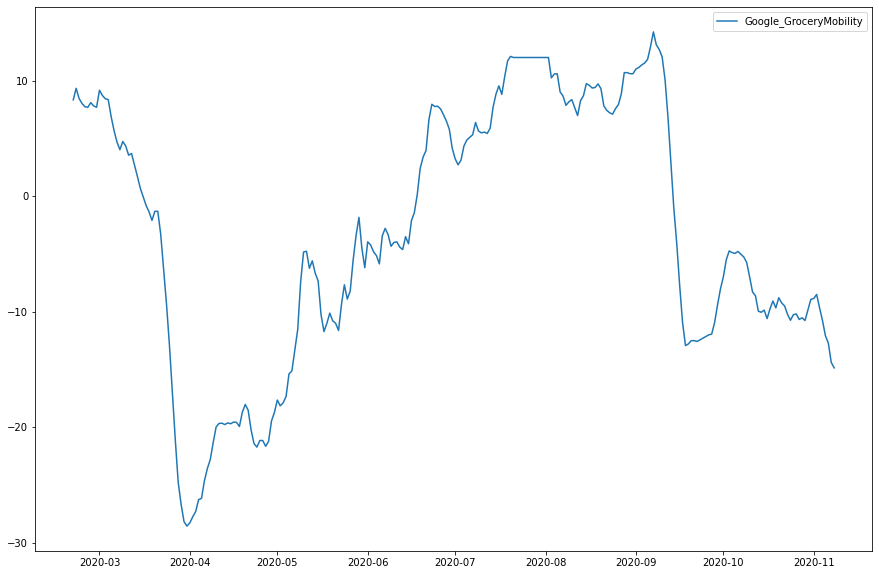

In [420]:
plt.figure(figsize = (15,10))
# plt.plot(df_wa["dates"],df_wa[metrics])
plt.plot(df_wa["dates"],df_wa['7day_avg'])
plt.legend(metrics)

In [421]:
# add zero column
df_wa['zeros'] = 0

In [422]:
df_wa.head()

,dates,7day_avg,Google_GroceryMobility,Google_ParksMobility,Google_TransitStationsMobility,Google_RetailMobility,Google_ResidentialMobility,Google_WorkplacesMobility,zeros
0,2020-02-15,NaN,-1.0,8.0,8.0,2.0,0.0,-3.0,0
1,2020-02-16,NaN,3.0,19.0,5.0,15.0,-1.0,-1.0,0
2,2020-02-17,NaN,2.0,63.0,-7.0,12.0,6.0,-35.0,0
3,2020-02-18,NaN,2.0,52.0,7.0,5.0,0.0,-4.0,0
4,2020-02-19,NaN,3.0,60.0,7.0,4.0,-1.0,-2.0,0


In [423]:
# rename columns
# column_indices = range(1,8)
# new_names = ['7-day rolling average','Grocery','Parks','Transit Stations','Retail','Residential','Workplaces']
# old_names = df_wa.columns[column_indices]
# df_wa.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [424]:
# df_wa.to_csv("washington_mobility.csv")

**social distance restrictions map**

In [425]:
df_policy = c3aidatalake.fetch(
    "locationpolicysummary",
    {
  "spec" : {
    # "filter": "location == 'Pennsylvania_UnitedStates'",
    # "include": "productType, description, origin, links.url",
    # "limit": 6
    }
  },
    get_all = True
)

df_policy.head()

,easingOrder,stayAtHome,mandatoryQuarantine,nonEssentialBusiness,largeGatherings,schoolClosure,restaurantLimit,barClosures,faceCoveringRequirement,PrimaryElectionPostponement,emergencyDeclaration,waiveTreatmentCost,freeVaccine,waiverOfPriorAuthorizationRequirements,prescriptionRefill,premiumPaymentGracePeriod,marketplaceSpecialEnrollmentPeriod,section1135Waiver,paidSickLeaves,expandsAccesstoTelehealthServices,id,lastSavedTimestamp,numSavedVersions,savedVersion,location.id
0,Paused,Lifted,No Action,All Non-Essential Businesses Permitted to Reop...,Lifted,Closed for School Year,Reopened to Dine-in Service,Reopened,Required for General Public,No,Yes,No Action,No Action,No Action,No Action,No Action,No,Approved,No Action,No,Alabama_UnitedStates_Policy,2020-09-12T02:52:54Z,6,-1,Alabama_USA
1,Proceeding with Reopening,Lifted,All Travelers,All Non-Essential Businesses Permitted to Reopen,Lifted,Closed for School Year,Reopened to Dine-in Service,Reopened,Required for Certain Employees,No,Yes,No Action,No Action,No Action,State Requires,Expired,No,Approved,No Action,Yes,Alaska_UnitedStates_Policy,2020-09-12T02:52:54Z,5,-1,Alaska_UnitedStates
2,New Restrictions Imposed,Lifted,Lifted,New Business Closures or Limits,New Limit on Large Gatherings in Place,Closed for School Year,New Service Limits,Newly Closed,Required for Certain Employees; Allows Local O...,No,Yes,No Action,No Action,No Action,No Action,No Action,No,Approved,Enacted,Yes,Arizona_UnitedStates_Policy,2020-09-12T02:52:54Z,5,-1,Arizona_UnitedStates
3,Paused,No Action,Lifted,No Action,Lifted,Closed for School Year,Reopened to Dine-in Service with Capacity Limits,Reopened,Required for General Public,No,Yes,No Action,No Action,No Action,No Action,COVID-19 Diagnosis/Impacts Only,No,Approved,No Action,Yes,Arkansas_UnitedStates_Policy,2020-09-12T02:52:54Z,4,-1,Arkansas_UnitedStates
4,New Restrictions Imposed,Statewide,No Action,New Business Closures or Limits,All Gatherings Prohibited,Recommended Closure for School Year,Newly Closed to Dine-in Service,Newly Closed,Required for General Public,No,Yes,No Action,No Action,No Action,State Requires,No Action,Active,Approved,Enacted,Yes,California_UnitedStates_Policy,2020-09-12T02:52:54Z,5,-1,California_UnitedStates


In [426]:
df_hospital = c3aidatalake.fetch(
    "hospital",
    {
  "spec" : {
    }
  },
    get_all = True
)

df_hospital.head()

,name,hospitalType,address,staffedBeds,licensedBeds,icuBeds,icuBedsAdult,icuBedsPotential,ventilatorUsage,lat,lon,id,location.id,icuBedsPedi,bedUtilization
0,Phoenix VA Health Care System (AKA Carl T Hayd...,VA Hospital,"650 E Indian School Rd,Phoenix,85012,AZ,USA",62.0,62.0,0,0,0,0.0,33.4955,-112.0660,1,Maricopa_Arizona_UnitedStates,NaN,NaN
1,Merit Health River Oaks (FKA River Oaks Hospit...,Short Term Acute Care Hospital,"1030 River Oaks Dr,Flowood,39232,MS,USA",160.0,160.0,10,10,0,2.0,32.3255,-90.1053,10,Rankin_Mississippi_UnitedStates,20.0,0.296567
2,Walker Baptist Medical Center,Short Term Acute Care Hospital,"3400 Highway 78 E,Jasper,35501,AL,USA",207.0,267.0,12,12,60,4.0,33.8298,-87.2081,100,Walker_Alabama_UnitedStates,0.0,0.287486
3,Wahiawa General Hospital,Short Term Acute Care Hospital,"128 Lehua St,Wahiawa,96786,HI,USA",43.0,42.0,6,6,-1,2.0,21.4990,-158.0260,1000,Honolulu_Hawaii_UnitedStates,0.0,0.326155
4,The Queens Medical Center,Short Term Acute Care Hospital,"1301 Punchbowl St,Honolulu,96813,HI,USA",650.0,535.0,58,58,-115,9.0,21.3085,-157.8540,1001,Honolulu_Hawaii_UnitedStates,0.0,0.757749


hospital heatmaps

In [427]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'AmericanSamoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'DistrictofColumbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'NewHampshire': 'NH',
    'NewJersey': 'NJ',
    'NewMexico': 'NM',
    'NewYork': 'NY',
    'NorthCarolina': 'NC',
    'NorthDakota': 'ND',
    'NorthernMarianaIslands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'PuertoRico': 'PR',
    'RhodeIsland': 'RI',
    'SouthCarolina': 'SC',
    'SouthDakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'VirginIslands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'WestVirginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [428]:
df_hospital['state'] = df_hospital['location.id'].str.split('_').str[1]
df_hospital['code'] = df_hospital['state'].map(us_state_abbrev)

In [429]:
df_hospital['code'].isnull().sum()

25

In [430]:
df_hospital[df_hospital['code'] == 'WA']['licensedBeds']

1332     49.0
1336     62.0
1337     25.0
1338    111.0
1339    270.0
        ...  
90      100.0
129       NaN
131       NaN
138     644.0
230       NaN
Name: licensedBeds, Length: 119, dtype: float64

In [431]:
# compute the total icu beds in each state
df_hospital_tot = df_hospital.groupby(['code'])['icuBeds'].agg('sum')

In [432]:
df_hospital_tot = pd.DataFrame({'code':df_hospital_tot.index, 'tot_icu':df_hospital_tot.values})

In [433]:
import plotly.graph_objects as go

import pandas as pd
df = df_hospital_tot

for col in df.columns:
    df[col] = df[col].astype(str)

df['text'] = df['code'] 

fig = go.Figure(data=go.Choropleth(
    locations=df['code'],
    z=df['tot_icu'].astype(float),
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
    text=df['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="# ICU units"
))

fig.update_layout(
    title_text='US hospital ICU units distribution map',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

In [434]:
states = [
    'Alabama_UnitedStates','Alaska_UnitedStates','Arizona_UnitedStates',
    'Arkansas_UnitedStates','California_UnitedStates','Colorado_UnitedStates',
    'Connecticut_UnitedStates','Delaware_UnitedStates','DistrictofColumbia_UnitedStates',
    'Florida_UnitedStates','Georgia_UnitedStates','Hawaii_UnitedStates',
    'Idaho_UnitedStates','Illinois_UnitedStates','Indiana_UnitedStates',
    'Iowa_UnitedStates','Kansas_UnitedStates','Kentucky_UnitedStates',
    'Louisiana_UnitedStates','Maine_UnitedStates','Maryland_UnitedStates',
    'Massachusetts_UnitedStates','Michigan_UnitedStates','Minnesota_UnitedStates',
    'Mississippi_UnitedStates','Missouri_UnitedStates','Montana_UnitedStates',
    'Nebraska_UnitedStates','Nevada_UnitedStates','NewHampshire_UnitedStates',
    'NewJersey_UnitedStates','NewMexico_UnitedStates','NewYork_UnitedStates',
    'NorthCarolina_UnitedStates','NorthDakota_UnitedStates','Ohio_UnitedStates',
    'Oklahoma_UnitedStates','Oregon_UnitedStates','Pennsylvania_UnitedStates',
    'PuertoRico_UnitedStates','RhodeIsland_UnitedStates','SouthCarolina_UnitedStates',
    'SouthDakota_UnitedStates','Tennessee_UnitedStates','Texas_UnitedStates',
    'Utah_UnitedStates','Vermont_UnitedStates','Virginia_UnitedStates',
    'Washington_UnitedStates','WestVirginia_UnitedStates','Wisconsin_UnitedStates',
    'Wyoming_UnitedStates'
]

In [435]:
counties = c3aidatalake.fetch(
    "outbreaklocation",
    {
        "spec" : {
            "include" : "id",
            "filter" : "contains(id, 'UnitedStates') && locationType == 'county'"
        }
    },
    get_all = True
).id.tolist()

age demographics

In [436]:
state_from_location = lambda x: "_".join(x.split('_')[-2:]).replace("_UnitedStates", "")
population_limits = (
    f"contains(parent, 'UnitedStates') &&" # US data
    "(populationAge == '>=65' || populationAge == 'Total' || populationAge == '>=18') && " # Limit age groups
    "gender == 'Male/Female' && year == 2018 && origin == 'United States Census'" # From 2018 estimates
)

census = c3aidatalake.fetch(
    "populationdata",
    {
      "spec": {
        "filter": population_limits
      }
    },
    get_all = True
)

census['state'] = census['parent.id'].apply(state_from_location)
census = census.rename(columns={'parent.id': 'location'})

In [437]:
census_cols = [
    "populationAge",
    "value",
    "location",
    "state"
]

census_by_state = (
    census[census_cols]
    .loc[census.state.isin(map(lambda x: x.replace("_UnitedStates", ""), states))]
    .groupby(["state", "populationAge"])['value']
    .sum()
    .unstack("populationAge")
    .reset_index()
)

census_by_state.columns = ['state', 'over18', 'over65', 'total']
census_by_state['olderPerc'] = census_by_state.over65 * 100 / census_by_state.total
census_by_state['youngerPerc'] = (census_by_state.total - census_by_state.over18) * 100 / census_by_state.total

In [438]:
census

,year,gender,race,ethnicity,populationAge,estimate,median,percent,value,minAge,origin,id,timestamp,location,state
0,2018,Male/Female,Any race,Hispanic/Not Hispanic,>=18,True,False,False,19617.0,18.0,United States Census,2018_Abbeville_SouthCarolina_UnitedStates_Male...,2018-01-01T00:00:00Z,Abbeville_SouthCarolina_UnitedStates,SouthCarolina
1,2018,Male/Female,Any race,Hispanic/Not Hispanic,>=65,True,False,False,5343.0,65.0,United States Census,2018_Abbeville_SouthCarolina_UnitedStates_Male...,2018-01-01T00:00:00Z,Abbeville_SouthCarolina_UnitedStates,SouthCarolina
2,2018,Male/Female,Any race,Hispanic/Not Hispanic,Total,True,False,False,24541.0,NaN,United States Census,2018_Abbeville_SouthCarolina_UnitedStates_Male...,2018-01-01T00:00:00Z,Abbeville_SouthCarolina_UnitedStates,SouthCarolina
3,2018,Male/Female,Any race,Hispanic/Not Hispanic,>=18,True,False,False,46116.0,18.0,United States Census,2018_Acadia_Louisiana_UnitedStates_Male/Female...,2018-01-01T00:00:00Z,Acadia_Louisiana_UnitedStates,Louisiana
4,2018,Male/Female,Any race,Hispanic/Not Hispanic,>=65,True,False,False,9491.0,65.0,United States Census,2018_Acadia_Louisiana_UnitedStates_Male/Female...,2018-01-01T00:00:00Z,Acadia_Louisiana_UnitedStates,Louisiana
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700,2018,Male/Female,Any race,Hispanic/Not Hispanic,>=65,True,False,False,1712.0,65.0,United States Census,2018_Zavala_Texas_UnitedStates_Male/Female_>=6...,2018-01-01T00:00:00Z,Zavala_Texas_UnitedStates,Texas
1701,2018,Male/Female,Any race,Hispanic/Not Hispanic,Total,True,False,False,11983.0,NaN,United States Census,2018_Zavala_Texas_UnitedStates_Male/Female_Tot...,2018-01-01T00:00:00Z,Zavala_Texas_UnitedStates,Texas
1702,2018,Male/Female,Any race,Hispanic/Not Hispanic,>=18,True,False,False,1968.0,18.0,United States Census,2018_Ziebach_SouthDakota_UnitedStates_Male/Fem...,2018-01-01T00:00:00Z,Ziebach_SouthDakota_UnitedStates,SouthDakota
1703,2018,Male/Female,Any race,Hispanic/Not Hispanic,>=65,True,False,False,263.0,65.0,United States Census,2018_Ziebach_SouthDakota_UnitedStates_Male/Fem...,2018-01-01T00:00:00Z,Ziebach_SouthDakota_UnitedStates,SouthDakota


Excess mortality due to COVID

In [439]:
df_mortality = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
      "spec": {
        "ids": ["Austria", "Denmark"],
        "expressions": ["NYT_AllCausesDeathsWeekly_Excess_Deaths"],
        "start": "2020-04-01",
        "end": "2020-05-01",
        "interval":"DAY"
      }
    },
    get_all = True
)


In [440]:
df_mortality.columns

Index(['dates', 'Austria.NYT_AllCausesDeathsWeekly_Excess_Deaths.data',
       'Austria.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing',
       'Denmark.NYT_AllCausesDeathsWeekly_Excess_Deaths.data',
       'Denmark.NYT_AllCausesDeathsWeekly_Excess_Deaths.missing'],
      dtype='object')

death rate trend in the past ~100 days


In [441]:
# death number/rate in the past 50 days
today = pd.Timestamp.now() 
today = today.strftime("%Y-%m-%d")
today_minus50 = pd.Timestamp.now() - datetime.timedelta(days = 110)
today_minus50 = today_minus50.strftime("%Y-%m-%d")

metrics = [
    "JHU_ConfirmedCases",
    # "JHU_ConfirmedDeaths"
]

complete_timeseries = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : states,
            "expressions" : metrics,
            # "start" : today_minus50,
            "start" : "2020-02-15",
            "end" : today,
            "interval" : "DAY",
        }
    },
    get_all = True
)

In [442]:
complete_timeseries = complete_timeseries.loc[:, (complete_timeseries != 0).any(axis=0)]

In [443]:
complete_timeseries.columns = complete_timeseries.columns.str.replace('_UnitedStates.JHU_ConfirmedCases.data','')
complete_timeseries.columns = complete_timeseries.columns.str.replace('_UnitedStates.JHU_ConfirmedDeaths.data','')

In [444]:
complete_timeseries.reset_index(inplace=True, drop=True)

In [445]:
# number of new cases/deaths per day
new_cases = complete_timeseries.set_index('dates').diff()
new_cases.head()

,Alabama,Alabama_UnitedStates.JHU_ConfirmedCases.missing,Colorado,Florida,Connecticut,DistrictofColumbia,Alaska,California,Arkansas,Arizona,Delaware,Kentucky,Kansas,Georgia,Iowa,Idaho,Louisiana,Illinois,Maine,Hawaii,Indiana,Minnesota,Massachusetts,Nebraska,Maryland,Missouri,Nevada,Michigan,Mississippi,Montana,NewHampshire,Ohio,Pennsylvania,Oklahoma,Oregon,NorthDakota,NewMexico,NewYork,PuertoRico,NewJersey,NorthCarolina,SouthCarolina,RhodeIsland,Utah,Vermont,WestVirginia,Tennessee,Texas,Washington,SouthDakota,Virginia,Wyoming,Wisconsin
dates,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-02-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-02-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-02-19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [446]:
case_wa = new_cases['Washington']

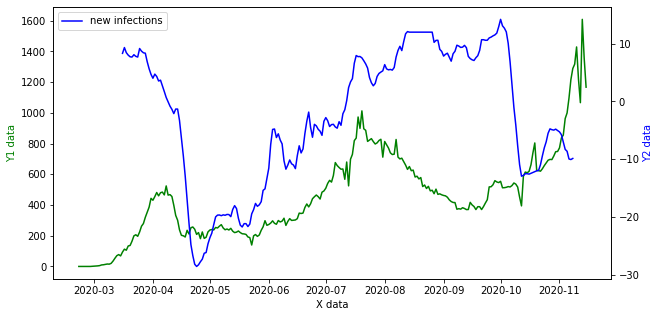

In [447]:
# compare mobility and infections
fig, ax1 = plt.subplots(figsize=(10,5))

ax2 = ax1.twinx()
ax1.plot(complete_timeseries['dates'],case_wa.rolling(window=7).mean().reset_index(0,drop=True), 'g-')
ax2.plot(df_wa['dates'],df_wa['7day_avg'].shift(24), 'b-')
# ax2.plot(df_wa['dates'],np.cumsum(df_wa['7day_avg']), 'b-')
ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')
plt.legend(['new infections','mobility'])
plt.show()

In [469]:
# df_tmp = pd.DataFrame()
# df_tmp['dates'] = df_wa['dates']
# df_tmp['mobility'] = df_wa['7day_avg'].shift(24)
# df_tmp['cases'] = case_wa.rolling(window=7).mean().reset_index(0,drop=True)
# df_tmp.to_csv('mobilitycorr.csv')

In [448]:
df_mobility.head()

,dates,country,states,country2,Google_GroceryMobility,Google_ParksMobility,Google_TransitStationsMobility,Google_RetailMobility,Google_ResidentialMobility,Google_WorkplacesMobility,avg,7day_avg
0,2020-02-15,AmericanSamoa,AmericanSamoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-15,Guam,Guam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-15,NorthernMarianaIslands,NorthernMarianaIslands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-15,PuertoRico,PuertoRico,NaN,0.0,9.0,-4.0,2.0,0.0,-3.0,0.666667,NaN
4,2020-02-15,VirginIslands,VirginIslands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


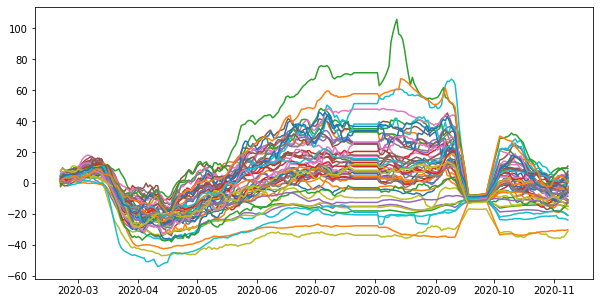

In [449]:
# time series of mobility in each state
df_mob_all = pd.DataFrame()
df_mob_all['dates'] = df_mobility['dates'].unique()
fig, ax1 = plt.subplots(figsize=(10,5))

# ax1.plot(df_wa['dates'],df_wa['7day_avg'].shift(24), 'b-')
for s in states:
  s1 = s.split('_')[0]
  df_tmp = df_mobility[df_mobility["states"] == s1]
  df_tmp = df_tmp.fillna(method='ffill')
  df_mob_all[s1] = df_tmp['7day_avg'].reset_index()['7day_avg']
  ax1.plot(df_tmp['dates'],df_tmp['7day_avg'])

plt.show()

In [450]:
df_mobility[df_mobility["states"] == 'SouthDakota']

,dates,country,states,country2,Google_GroceryMobility,Google_ParksMobility,Google_TransitStationsMobility,Google_RetailMobility,Google_ResidentialMobility,Google_WorkplacesMobility,avg,7day_avg
46,2020-02-15,SouthDakota,SouthDakota,NaN,6.0,4.0,3.0,7.0,0.0,-1.0,3.166667,NaN
104,2020-02-16,SouthDakota,SouthDakota,NaN,11.0,28.0,1.0,15.0,-2.0,1.0,9.000000,NaN
162,2020-02-17,SouthDakota,SouthDakota,NaN,0.0,-7.0,4.0,3.0,6.0,-23.0,-2.833333,NaN
220,2020-02-18,SouthDakota,SouthDakota,NaN,1.0,-2.0,0.0,-5.0,1.0,-1.0,-1.000000,NaN
278,2020-02-19,SouthDakota,SouthDakota,NaN,-1.0,-4.0,1.0,-5.0,1.0,1.0,-1.166667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
15300,2020-11-04,SouthDakota,SouthDakota,NaN,5.0,74.0,-3.0,-8.0,6.0,-20.0,9.000000,9.238095
15358,2020-11-05,SouthDakota,SouthDakota,NaN,2.0,78.0,0.0,-7.0,6.0,-19.0,10.000000,9.904762
15416,2020-11-06,SouthDakota,SouthDakota,NaN,5.0,66.0,-1.0,-6.0,7.0,-17.0,9.000000,9.952381
15474,2020-11-07,SouthDakota,SouthDakota,NaN,7.0,53.0,-3.0,-9.0,4.0,-7.0,7.500000,9.928571


In [451]:
# df_mob_all.to_csv('all_states_mobility.csv')

In [452]:
df_wa = df_wa.merge(case_wa, on='dates', how='left')

In [453]:
# lag correlation
max_lag = 50
lagged_correlation = pd.DataFrame.from_dict(
    {x: [pd.to_numeric(df_wa['Washington']).corr(pd.to_numeric(df_wa[x]).shift(t)) for t in range(max_lag)] for x in df_wa.columns})

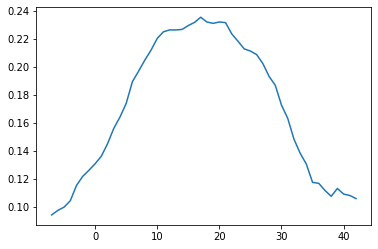

In [454]:
plt.plot(np.arange(max_lag)-7,lagged_correlation['7day_avg'])

In [455]:
df_wa['nmob'] = 1- (df_wa['7day_avg'] - df_wa['7day_avg'].min())/(df_wa['7day_avg'].max() - df_wa['7day_avg'].min())

In [456]:
df_wa['cum_death'] = (df_wa['Washington'] - df_wa['Washington'].min())/(df_wa['Washington'].max() - df_wa['Washington'].min())

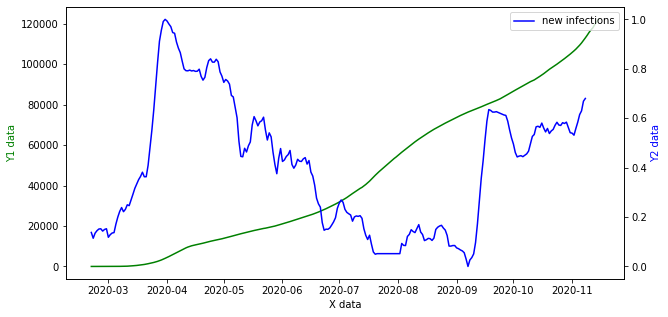

In [457]:
# mobility vs. cum deaths
fig, ax1 = plt.subplots(figsize=(10,5))

ax2 = ax1.twinx()
ax1.plot(complete_timeseries['dates'],complete_timeseries['Washington'].rolling(window=7).mean().reset_index(0,drop=True), 'g-')
# ax1.plot(df_wa['dates'],df_wa['cum_death'], 'g-')
ax2.plot(df_wa['dates'],df_wa['nmob'], 'b-') # normalized mobility
# ax2.plot(df_wa['dates'],df_wa['7day_avg'])
# ax2.plot(df_wa['dates'],df_wa['nmob'])

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='g')
ax2.set_ylabel('Y2 data', color='b')
plt.legend(['new infections','mobility'])
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log



(5.0, 7.0)

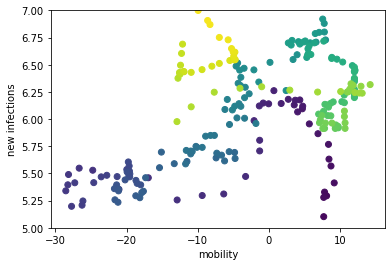

In [458]:
plt.scatter(df_wa['7day_avg'].shift(24), np.log(df_wa['Washington'].rolling(window=7).mean().reset_index(0,drop=True)), c=df_wa.index)
plt.xlabel('mobility')
plt.ylabel('new infections')
plt.ylim([5,7])

In [459]:
complete_timeseries.at[0,'dates'] = complete_timeseries.at[len(complete_timeseries)-1,'dates'] 

In [460]:
complete_timeseries = complete_timeseries - complete_timeseries.iloc[0].values.squeeze()

In [461]:
complete_timeseries.at[0,1:] = 10 # align all states to start from 10

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3159: FutureWarning:

Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.



In [462]:
complete_timeseries.at[0,'dates'] -=  datetime.timedelta(days = len(complete_timeseries)-1)

In [463]:
complete_timeseries.head()

,dates,Alabama,Alabama_UnitedStates.JHU_ConfirmedCases.missing,Colorado,Florida,Connecticut,DistrictofColumbia,Alaska,California,Arkansas,Arizona,Delaware,Kentucky,Kansas,Georgia,Iowa,Idaho,Louisiana,Illinois,Maine,Hawaii,Indiana,Minnesota,Massachusetts,Nebraska,Maryland,Missouri,Nevada,Michigan,Mississippi,Montana,NewHampshire,Ohio,Pennsylvania,Oklahoma,Oregon,NorthDakota,NewMexico,NewYork,PuertoRico,NewJersey,NorthCarolina,SouthCarolina,RhodeIsland,Utah,Vermont,WestVirginia,Tennessee,Texas,Washington,SouthDakota,Virginia,Wyoming,Wisconsin
0,-274 days,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
1,-273 days,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-272 days,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-271 days,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-270 days,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [464]:
# save to csv
# complete_timeseries.to_csv(r'death.csv')

mobility map changes (%)

In [465]:
df_mobility.head()

,dates,country,states,country2,Google_GroceryMobility,Google_ParksMobility,Google_TransitStationsMobility,Google_RetailMobility,Google_ResidentialMobility,Google_WorkplacesMobility,avg,7day_avg
0,2020-02-15,AmericanSamoa,AmericanSamoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-02-15,Guam,Guam,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-02-15,NorthernMarianaIslands,NorthernMarianaIslands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-02-15,PuertoRico,PuertoRico,NaN,0.0,9.0,-4.0,2.0,0.0,-3.0,0.666667,NaN
4,2020-02-15,VirginIslands,VirginIslands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [468]:
import plotly.graph_objects as go
import pandas as pd

df2 = df_mobility.loc[df_mobility['dates'] == "2020-03-01"].reset_index(drop = True)
df = df_mobility.loc[df_mobility['dates'] == "2020-10-15"].reset_index(drop = True)

df['code'] = df['states'].map(us_state_abbrev)
for col in df.columns:
    df[col] = df[col].astype(str)

df['text'] = df['states'] 
df['change'] = (df['avg'].astype(float) - df2['avg'].astype(float)) #%

fig = go.Figure(data=go.Choropleth(
    locations=df['code'],
    z=df['change'].astype(float),
    locationmode='USA-states',
    colorscale='Reds',
    autocolorscale=False,
    text=df['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_title="\u0394Mobility"
))

fig.update_layout(
    title_text='COVID-induced changes in mobility (%)',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)

fig.show()

In [ ]:
# df[['dates','states','avg','change','code']].to_csv('mobilitymap.csv')